Get the dataset

In [1]:
!pip3 install keras
!pip3 install tensorboard

In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('data/loan_approval_dataset.csv')
#Exclude first column (id) from X and reorder the columns
dataset = dataset[['Gender','Married','Education','Self_Employed','Property_Area','Dependents','Credit_History',
                  'ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Loan_Status']]
dataset.iloc[:5,:]

,Gender,Married,Education,Self_Employed,Property_Area,Dependents,Credit_History,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,Male,No,Graduate,No,Urban,0,1.0,5849,0.0,NaN,360.0,Y
1,Male,Yes,Graduate,No,Rural,1,1.0,4583,1508.0,128.0,360.0,N
2,Male,Yes,Graduate,Yes,Urban,0,1.0,3000,0.0,66.0,360.0,Y
3,Male,Yes,Not Graduate,No,Urban,0,1.0,2583,2358.0,120.0,360.0,Y
4,Male,No,Graduate,No,Urban,0,1.0,6000,0.0,141.0,360.0,Y


In [3]:

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

# Column 5 (Dependents) - 3+ => 3
for i in range(X.shape[0]):
  if(X[i,5] == '3+'):
    X[i,5] = 3

# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 5:])
X[:, 5:] = imputer.transform(X[:, 5:])

In [4]:
# Encoding the categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
X[:, :5] = np.apply_along_axis(LabelEncoder().fit_transform,axis=1, arr=X[:, :5].astype('str'))
y = LabelEncoder().fit_transform(y.ravel())
onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4])
X = onehotencoder.fit_transform(X).toarray()

In [5]:
# Feature Scaling for numerical data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[:,20:] = sc.fit_transform(X[:,20:])

In [6]:
pd.DataFrame(X).iloc[:5,:]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.45164,0.072991,-0.554487,3.384786e-16,0.279851
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.45164,-0.134412,-0.038732,-2.192733e-01,0.279851
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.45164,-0.393747,-0.554487,-9.576410e-01,0.279851
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.45164,-0.462062,0.251980,-3.145466e-01,0.279851
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.45164,0.097728,-0.554487,-6.445428e-02,0.279851


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# 2. Models

## 2.1 Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def logistic_regression(X_train, y_train, X_test, y_test):
  classifier = LogisticRegression()
  classifier.fit(X_train, y_train)
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred,y_test)

def show_results(training_eval, test_eval):
  plt.gca().set_ylim([0,1])
  plt.plot(training_eval, label='Training Accuracy')
  plt.plot(test_eval, label='Test Accuracy')
  plt.legend()
  plt.xlabel('Training set size')
  plt.ylabel('Accuracy')
  plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


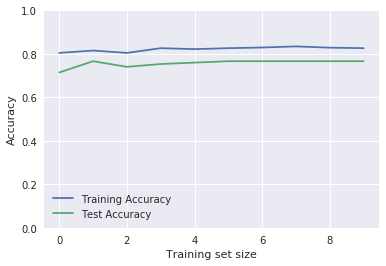

In [9]:
lr_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Logistic Regression {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [lr_eval.values[i,0],lr_eval.values[i,1]] = logistic_regression(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(lr_eval['train'], lr_eval['test'])

## 2.2 K-Nearest Neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
def knn(X_train,y_train,X_test,y_test):
  classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
  classifier.fit(X_train, y_train)
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


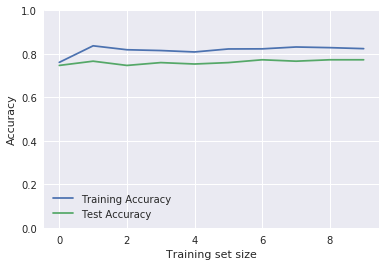

In [11]:
knn_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('KNN {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [knn_eval.values[i,0],knn_eval.values[i,1]] = knn(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(knn_eval['train'], knn_eval['test'])

## 2.3 Support Vector Machine

In [12]:
from sklearn.svm import SVC

def svm(X_train, y_train, X_test, y_test):
  classifier = SVC(kernel = 'rbf')
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


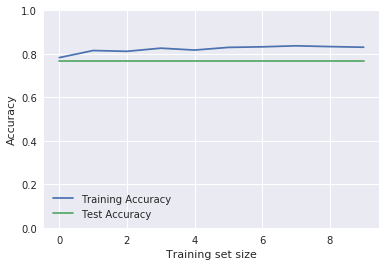

In [13]:
svm_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('SVM {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [svm_eval.values[i,0],svm_eval.values[i,1]] = svm(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(svm_eval['train'], svm_eval['test'])

## 2.4 Naives Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
  
def naive_bayes(X_train, y_train, X_test, y_test):
  classifier = GaussianNB()
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


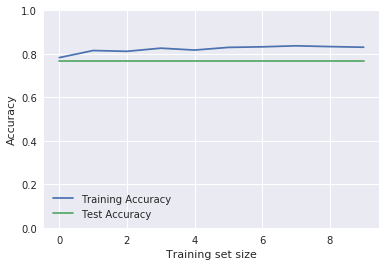

In [15]:
nb_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Naives Bayes {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [nb_eval.values[i,0],nb_eval.values[i,1]] = svm(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(nb_eval['train'], nb_eval['test'])

## 2.5 Random Forest Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X_train,y_train,X_test,y_test):
  classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


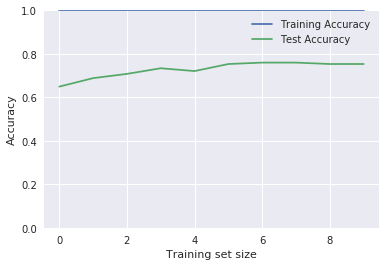

In [17]:
rf_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Random Forest {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [rf_eval.values[i,0],rf_eval.values[i,1]] = random_forest(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(rf_eval['train'], rf_eval['test'])

## 2.6 Deep Neural Network

In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from time import time
from keras.callbacks import TensorBoard
from google.datalab.ml import TensorBoard as tb # if running from a Google Cloud Platform Datalab

def dnn(X_train,y_train,X_test,y_test):
  tensorboard = TensorBoard(log_dir='logs/bs3e100')
  classifier = Sequential()
  classifier.add(Dense(input_dim = 25, units = 50, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 25, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 10, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  classifier.fit(X_train,y_train, batch_size = 3, epochs = 100, callbacks=[tensorboard])
  y_test_pred = classifier.predict(X_test)
  y_test_pred = (y_test_pred > 0.5)
  y_train_pred = classifier.predict(X_train)
  y_train_pred = (y_train_pred > 0.5)
  return accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

Epoch 1/100
460/460 [==============================] - 1s 1ms/step - loss: 0.6334 - acc: 0.6935
Epoch 2/100
460/460 [==============================] - 0s 533us/step - loss: 0.5003 - acc: 0.7891
Epoch 3/100
460/460 [==============================] - 0s 557us/step - loss: 0.4658 - acc: 0.8196
Epoch 4/100
460/460 [==============================] - 0s 542us/step - loss: 0.4436 - acc: 0.8283
Epoch 5/100
460/460 [==============================] - 0s 562us/step - loss: 0.4402 - acc: 0.8283
Epoch 6/100
460/460 [==============================] - 0s 603us/step - loss: 0.4369 - acc: 0.8304
Epoch 7/100
460/460 [==============================] - 0s 617us/step - loss: 0.4350 - acc: 0.8261
Epoch 8/100
460/460 [==============================] - 0s 599us/step - loss: 0.4339 - acc: 0.8261
Epoch 9/100
460/460 [==============================] - 0s 694us/step - loss: 0.4273 - acc: 0.8326
Epoch 10/100
460/460 [==============================] - 0s 834us/step - loss: 0.4246 - acc: 0.8326
Epoch 11/100
460/460 

460/460 [==============================] - 0s 578us/step - loss: 0.2846 - acc: 0.8891
Epoch 84/100
460/460 [==============================] - 0s 542us/step - loss: 0.3210 - acc: 0.8717
Epoch 85/100
460/460 [==============================] - 0s 570us/step - loss: 0.2792 - acc: 0.8957
Epoch 86/100
460/460 [==============================] - 0s 549us/step - loss: 0.2712 - acc: 0.9109
Epoch 87/100
460/460 [==============================] - 0s 569us/step - loss: 0.2712 - acc: 0.9022
Epoch 88/100
460/460 [==============================] - 0s 548us/step - loss: 0.2655 - acc: 0.9109
Epoch 89/100
460/460 [==============================] - 0s 601us/step - loss: 0.2641 - acc: 0.9087
Epoch 90/100
460/460 [==============================] - 0s 585us/step - loss: 0.2660 - acc: 0.9065
Epoch 91/100
460/460 [==============================] - 0s 599us/step - loss: 0.2745 - acc: 0.8978
Epoch 92/100
460/460 [==============================] - 0s 651us/step - loss: 0.2684 - acc: 0.9130
Epoch 93/100
460/460 [=

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


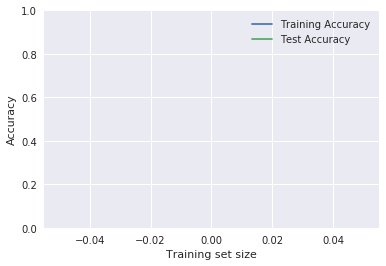

In [47]:
dnn_eval = pd.DataFrame(0, index=range(1), columns=['train', 'test']).astype(float)

[dnn_eval.values[0,0],dnn_eval.values[0,1]] = dnn(X_train, y_train, X_test, y_test)
  
show_results(dnn_eval['train'], dnn_eval['test'])

In [27]:
tb.start('./logs') # Only start if it has not been started yet

TensorBoard was started successfully with pid 5510. Click here to access it.

5510

# Conclusion

In [48]:
print(lr_eval)
print(knn_eval)
print(svm_eval)
print(rf_eval)
print(dnn_eval)

      train      test
0  0.804348  0.714286
1  0.815217  0.766234
2  0.804348  0.740260
3  0.826087  0.753247
4  0.821739  0.759740
5  0.826087  0.766234
6  0.829193  0.766234
7  0.834239  0.766234
8  0.828502  0.766234
9  0.826087  0.766234
      train      test
0  0.760870  0.746753
1  0.836957  0.766234
2  0.818841  0.746753
3  0.815217  0.759740
4  0.808696  0.753247
5  0.822464  0.759740
6  0.822981  0.772727
7  0.831522  0.766234
8  0.828502  0.772727
9  0.823913  0.772727
      train      test
0  0.782609  0.766234
1  0.815217  0.766234
2  0.811594  0.766234
3  0.826087  0.766234
4  0.817391  0.766234
5  0.829710  0.766234
6  0.832298  0.766234
7  0.836957  0.766234
8  0.833333  0.766234
9  0.830435  0.766234
   train      test
0    1.0  0.649351
1    1.0  0.688312
2    1.0  0.707792
3    1.0  0.733766
4    1.0  0.720779
5    1.0  0.753247
6    1.0  0.759740
7    1.0  0.759740
8    1.0  0.753247
9    1.0  0.753247
     train      test
0  0.91087  0.733766
